<h1>STOCK MARKET PREDICTION / ПРОГНОЗ ЦЕН НА ФОНДОВОМ РЫНКЕ</h1>

# <h3>Dataset preparation / Подготовка датасета</h3>
*Data is taken from Finam brokerage firm website (https://www.finam.ru/profile/forex/usd-rub/export/) / *Данные взяты с сайта брокерской компании Финам (https://www.finam.ru/profile/forex/usd-rub/export/)

In [ ]:
import os
if not os.path.exists("data"):
  os.system("mkdir -p ./data/days")

minimum date 2002-06-06 maximum date 2021-12-30
USD started from 31.42 finished at 74.4476 change 136.94 %


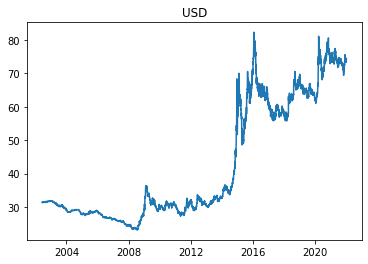

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import clear_output

import numpy as np
import datetime
import random
import matplotlib.pyplot as plt
import pandas as pd

def loadInfo(filename):
    #Read info from quote csv file
    if not os.path.exists(filename):
      os.system("wget https://raw.githubusercontent.com/igormelekhin/stock_prediction/main/"+filename+" -P ./data/days")
    df=pd.read_csv(filename)
    df=df.rename(columns={"<DATE>":"d","<TIME>":"t","<OPEN>":"o","<HIGH>":"h","<LOW>":"l","<CLOSE>":"c","<VOLUME>":"v"})
    df["d"]=df["d"].apply(lambda x: datetime.date(x//10000,(x//100)%100,x%100))
    df["t"]=df["t"].apply(lambda x: datetime.time(x//10000,(x//100)%100,x%100))
    return df

dateEnds={} #last results for each day
#dates of common intersection
minDate=datetime.date(1000,1,1)
maxDate=datetime.date(3000,1,1)
def loadAndAlign(name,filename):
    #Read the file and fill dateEnds for the stock
    global minDate,maxDate
    dateEnds[name]={}
    df=loadInfo(filename)
    lastDate=df.iloc[0]["d"]
    minDate=max(minDate,df.iloc[0]["d"])
    maxDate=min(maxDate,df.iloc[-1]["d"])
    for i in range(df.shape[0]-1):
        if df.iloc[i+1]["d"]!=lastDate:
            dateEnds[name][lastDate]=df.iloc[i]["c"]
            lastDate=df.iloc[i+1]["d"]

#read data from downloaded quote csv files
loadAndAlign("Wheet","data/days/US3.ZW_000101_211231.txt")
loadAndAlign("NatGas","data/days/NYMEX.NG_000101_211231.txt")
loadAndAlign("Brent","data/days/ICE.BRN_000101_211231.txt")
loadAndAlign("FuelOil","data/days/NYMEX.HO_000101_211231.txt")
loadAndAlign("Gold","data/days/comex.GC_000101_211231.txt")
loadAndAlign("USD","data/days/USDRUB_000101_211231.txt")
loadAndAlign("Petrol","data/days/NYMEX.XRB_000101_211231.txt")
loadAndAlign("IMOEX","data/days/IMOEX_000101_211231.txt")
loadAndAlign("Alum","data/days/LME.Alum_000101_211231.txt")
loadAndAlign("S&P","data/days/SANDP-500_000101_211231.txt")
loadAndAlign("CNY","data/days/USDCNY_000101_211231.txt")

print('minimum date',minDate,'maximum date',maxDate)
dateData={}

#normalizations for relative changes and absolute values
NORMALIZATION_K=0.1
normalization={}
normalization["CHANGES"]={}
normalization["ABS"]={}

def denorm(key,val,valType): #denormalization to get real values from normalized
    global normalization
    return val*normalization[valType][key][0]+normalization[valType][key][1]

def getDateChanges(dateData):
    global minDate,maxDate,normalization
    date=minDate
    for key in dateEnds:
        normalization["CHANGES"][key]=(NORMALIZATION_K,0)
    while date<=maxDate:
        dateData[date]={}
        for key in dateEnds:
            dateData[date][key]=0
            if not (date in dateEnds[key]):
                continue
            date2=date-datetime.timedelta(days=1)
            for i in range(30):
                if date2 in dateEnds[key]:
                    dateData[date][key]=(dateEnds[key][date]-dateEnds[key][date2])/dateEnds[key][date2]/NORMALIZATION_K
                    break
                date2=date2-datetime.timedelta(days=1)
        date+=datetime.timedelta(days=1)

def getDateAbsNorm(dateData):
    global minDate,maxDate,normalization
    date=minDate
    minVal,maxVal,sumVal,totVal={},{},{},{}
    for key in dateEnds:
        minVal[key],maxVal[key],sumVal[key],totVal[key]=dateEnds[key][minDate],dateEnds[key][minDate],0,0
    while date<=maxDate:
        dateData[date]={}
        for key in dateEnds:
            dateData[date][key]=0
            if date in dateEnds[key]:
                dateData[date][key]=dateEnds[key][date]
            else:
                date2=date-datetime.timedelta(days=1)
                for i in range(30):
                    if date2 in dateEnds[key]:
                        dateData[date][key]=dateEnds[key][date2]
                        break
                    date2=date2-datetime.timedelta(days=1)
            minVal[key]=min(minVal[key],dateData[date][key])
            maxVal[key]=max(maxVal[key],dateData[date][key])
            sumVal[key]+=dateData[date][key]
            totVal[key]+=1
        date+=datetime.timedelta(days=1)
    date=minDate
    while date<=maxDate:
        for key in dateEnds:
            dateData[date][key]=2*((dateData[date][key]-minVal[key])/(maxVal[key]-minVal[key])-0.5)
        date+=datetime.timedelta(days=1)
    for key in dateEnds:
        normalization["ABS"][key]=(0.5*(maxVal[key]-minVal[key]),(minVal[key]+maxVal[key])/2)

#fill quote information in absolute and relative change formats
dateData={"ABS":{},"CHANGES":{}}
getDateChanges(dateData["CHANGES"])
getDateAbsNorm(dateData["ABS"])

def plotPrice(name):
    #Plot price to check data
    global minDate,maxDate
    date=minDate
    vals=[]
    dates=[]
    while date<=maxDate:
        if date in dateEnds[name]:
            vals.append(dateEnds[name][date])
            dates.append(date)
        date+=datetime.timedelta(days=1)
    plt.plot(dates,vals)
    plt.title(name)
    print(name,'started from',vals[0],'finished at',vals[-1],'change {:.2f}'.format(100.*(vals[-1]/vals[0]-1.)),'%')
plotPrice("USD")

X shape (9, 4)
4502 days in training 2640 days in validation


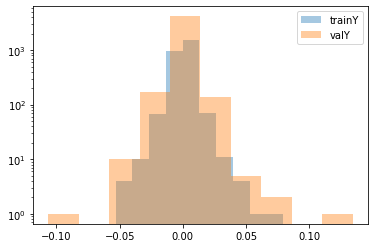

In [ ]:
def calcIndicator(data,indName,target):
  #Any required indicators calculated in addition to X. https://en.wikipedia.org/wiki/Technical_indicator
  if indName=="Weekday":
    return data[-1]["date"].weekday()/7
  if indName=="Monthday":
    return data[-1]["date"].day/31
  if indName=="Month":
    return data[-1]["date"].month/12
  if indName=="LowestTarget":
    res=data[0][target]
    for i in range(1,len(data)):
      res=min(res,data[i][target])
    return res
  if indName=="HighestTarget":
    res=data[0][target]
    for i in range(1,len(data)):
      res=max(res,data[i][target])
    return res

  '''
  ANY INDICATORS
  '''

  print(indName,'indicator not found')
  return 'indicator not found'

def makeXySplitted(raw,chunkSize,frames,target,use,valSplit,indicators):
    #Get randomly splitted X,y from raw data
    trainX,indTrainX,trainY,valX,indValX,valY,refs,prevRefs,prevY=[],[],[],[],[],[],[[],[]],[[],[]],[]
    date=minDate
    rawList=[]
    while date<=maxDate:
        rawList.append(raw[date])
        rawList[-1]["date"]=date
        date+=datetime.timedelta(days=1)
    raw=rawList
    splitChoice=np.zeros(len(raw))
    for i in range(len(raw)//chunkSize): #define dataset split according to chunksSize and valSplit ratio
      splitChoice[i*chunkSize:(i+1)*chunkSize]=random.random()<valSplit
    for i in range(len(raw)-frames-1):
        X=[]
        indX=[]
        for ind in indicators:
          indX.append(calcIndicator(raw[i:i+frames-1],ind,target))
        for key in raw[i]:
            if key!="date" and (key in use):
              X.append([])
              for j in range(frames-1):
                  X[-1].append(raw[i+j][key])
        y=raw[i+frames-1][target]
        if splitChoice[i]:
            valX.append(X)
            indValX.append(indX)
            valY.append(y)
            prevY.append(raw[i+frames-2][target])
            refs[0].append(raw[i+frames-1][target])
            refs[1].append(raw[i+frames-1]["S&P"])
            prevRefs[0].append(raw[i+frames-2][target])
            prevRefs[1].append(raw[i+frames-2]["S&P"])
        else:
            trainX.append(X)
            indTrainX.append(indX)
            trainY.append(y)
    return np.array(trainX),np.array(indTrainX),np.array(trainY),np.array(valX),np.array(indValX),np.array(valY),np.array(refs),np.array(prevRefs),np.array(prevY)  

def plotDistribution(y,log=False,title=""):
    #Plot distribution of y
    plt.hist(y,alpha=0.4,label=title)
    plt.legend()
    if log:
        plt.yscale('log')

def prepareRandomDataset(dateData,verb=False,params={}):
    #Main function to get prepared train and test datasets according to parameters
    defaultParams={"TYPE":"ABS","CHUNK_SIZE":20,"TARGET":"USD","VAL_SPLIT":0.35,"USE":["USD","S&P","Alum","IMOEX","Petrol","Gold","NatGas","Brent","CNY"],"FRAMES":5,"INDICATORS":["Weekday","Monthday","LowestTarget","HighestTarget"]}
    #default parameters fill missing values
    for p in defaultParams:
        if not(p in params):
            params[p]=defaultParams[p]
    trainX,indTrainX,trainY,valX,indValX,valY,refs,prevRefs,prevY=makeXySplitted(dateData[params["TYPE"]],params["CHUNK_SIZE"],params["FRAMES"],params["TARGET"],params["USE"],params["VAL_SPLIT"],params["INDICATORS"])
    if verb:
        print("X shape",trainX[0].shape)
        print(len(trainX),'days in training',len(valX),'days in validation')
        log=True
        plotDistribution(denorm(params["TARGET"],valY,params["TYPE"]),log,'trainY')
        plotDistribution(denorm(params["TARGET"],trainY,params["TYPE"]),log,'valY')
    return trainX,indTrainX,trainY,valX,indValX,valY,refs,prevRefs,prevY
        
trainX,indTrainX,trainY,valX,indValX,valY,valRefs,prevValRefs,prevY=prepareRandomDataset(dateData,True,{"TYPE":"CHANGES"})

The dataset should be split in such a way, that all the variety of results (y) is presented in both train and test datasets. "VAL_SPLIT" parameter defines the ratio of random split. <br>
/ Датасет должен быть разбит таким образом, чтобы все разнообразие результатов (y) было представлено как в обучающей, так и в тестовой выборке. Параметр "VAL_SPLIT" определяет соотношение случайного разбиения.

# <h3>Functions for model training / Функции для обучение моделей</h3>

## <h4>XGBoost</h4>

In [ ]:
import xgboost as xgb

def flatten(X,indX):
  #Make multichannel stock quotes and indicators as flat rows for each X
  return np.hstack([X.reshape((X.shape[0],X.shape[1]*X.shape[2])),indX])

def trainXGB(trainX,indTrainX,trainY,valX,indValX,params):
    model=xgb.XGBRegressor()
    model.fit(flatten(trainX,indTrainX),trainY)
    preds=model.predict(flatten(valX,indValX))
    return preds,None
    
preds,hist=trainXGB(trainX,indTrainX,trainY,valX,indValX,{})

[15:19:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## <h4>Tensorflow, Keras</h4>

In [ ]:
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import numpy as np

import tensorflow as tf
print('tensorflow version',tf.__version__)

def buildDense(params):
    #Build dense neural network model
    if not "DROPOUT" in params:
        params["DROPOUT"]=0
    inputQuotes=L.Input(params["INPUT_QUOTES"],name="Quotes")
    X=L.Flatten()(inputQuotes)
    inputIndicators=L.Input(params["INPUT_INDICATORS"],name="Indicators")
    X=L.Concatenate()([X,inputIndicators]) #X and indicators are concatenated
    for layer in params["LAYERS"]:
        X=L.Dense(layer,activation=None)(X)
        X=L.BatchNormalization()(X)
        if params["DROPOUT"]>0:
            X=L.Dropout(params["DROPOUT"])(X)
        X=L.Activation(activation=params["ACTIVATION"])(X)
    output=L.Dense(1,activation="tanh")(X)
    model = Model(inputs=[inputQuotes,inputIndicators], outputs=[output])
    return model

def buildCNN(params):
    #Build convolutional neural network model
    #default parameters
    if not "FILTER_SIZE" in params:
        params["FILTER_SIZE"]=3
    if not(type(params["FILTER_SIZE"]) is list):
        params["FILTER_SIZE"]=[params["FILTER_SIZE"]]*len(params["LAYERS"])
    if not "DROPOUT" in params:
        params["DROPOUT"]=0
    if not "DENSE_DROPOUT" in params:
        params["DENSE_DROPOUT"]=0
    if not "DENSE_LAYERS" in params:
        params["DENSE_LAYERS"]=[32]
    #layers
    inputQuotes=(L.Input(params["INPUT_QUOTES"],name="Quotes"))
    inputIndicators=(L.Input(params["INPUT_INDICATORS"],name="Indicators"))
    X=L.Reshape((params["INPUT_QUOTES"][0],params["INPUT_QUOTES"][1],1))(inputQuotes)
    for ind,layer in enumerate(params["LAYERS"]): #convolutional layers
        X=L.Conv1D(layer,params["FILTER_SIZE"][ind],activation=None)(X)
        X=L.BatchNormalization()(X)
        if params["DROPOUT"]>0:
            X=L.Dropout(params["DROPOUT"])(X)
        X=L.Activation(activation=params["ACTIVATION"])(X)
    X=L.Flatten()(X)
    indX=L.Flatten()(inputIndicators)
    X=L.Concatenate()([X,indX]) #results from convolutional layers and indicators are concatenated
    for layer in params["DENSE_LAYERS"]: #final dense layers
      X=L.Dense(layer,activation=None)(X)
      X=L.BatchNormalization()(X)
      if params["DENSE_DROPOUT"]>0:
          X=L.Dropout(params["DENSE_DROPOUT"])(X)
      X=L.Activation(activation=params["ACTIVATION"])(X)
    output=L.Dense(1,activation="tanh")(X)
    model = Model(inputs=[inputQuotes,inputIndicators], outputs=[output])
    return model
    
'''
ANY FUNCTIONS FOR MODELS AND LOSS
'''

def trainTF(trainX,indTrainX,trainY,valX,indValX,params):
    defaultParams={"MODEL":buildDense,"LAYERS":[64],"ACTIVATION":"relu","LOSS":"mse","ITERS":50,"OPTIMIZER":"Adam","LR":0.001,"VERB":0}
    for p in defaultParams:
        if not(p in params):
            params[p]=defaultParams[p]
    params["INPUT_QUOTES"]=trainX[0].shape
    params["INPUT_INDICATORS"]=indTrainX[0].shape
    model=params["MODEL"](params)
    model.compile(loss=params["LOSS"], optimizer=params["OPTIMIZER"])
    K.set_value(model.optimizer.learning_rate, params["LR"])
    hist=model.fit({"Quotes":trainX,"Indicators":indTrainX},trainY,epochs=params["ITERS"],validation_split=0.2,verbose=params["VERB"])
    preds=model.predict({"Quotes":valX,"Indicators":indValX})
    return preds,hist

preds2,hist2=trainTF(trainX,indTrainX,trainY,valX,indValX,{"ITERS":3,"LR":0.001,"VERB":2,"MODEL":buildCNN})

tensorflow version 2.8.2
Epoch 1/3
113/113 - 2s - loss: 0.2908 - val_loss: 0.0069 - 2s/epoch - 14ms/step
Epoch 2/3
113/113 - 0s - loss: 0.0449 - val_loss: 0.0045 - 470ms/epoch - 4ms/step
Epoch 3/3
113/113 - 0s - loss: 0.0205 - val_loss: 0.0041 - 494ms/epoch - 4ms/step


# <h3>Function for model predicions estimation / Функции для оценки точности прогноза моделей</h3>

Validation time 7.2 years, 2640 operations
Target hold -> 39.88%
S&P hold -> 219.85%
Confidense 0.0000 -> 199.07 % in 2639 operations ## Target mean hold -> 39.87% # S&P mean hold -> 219.77%
Confidense 0.0005 -> 192.46 % in 2439 operations ## Target mean hold -> 36.84% # S&P mean hold -> 203.11%
Confidense 0.0009 -> 177.90 % in 2243 operations ## Target mean hold -> 33.88% # S&P mean hold -> 186.79%
Confidense 0.0017 -> 167.83 % in 1847 operations ## Target mean hold -> 27.90% # S&P mean hold -> 153.81%
Confidense 0.0025 -> 150.49 % in 1583 operations ## Target mean hold -> 23.91% # S&P mean hold -> 131.83%
Confidense 0.0029 -> 135.19 % in 1451 operations ## Target mean hold -> 21.92% # S&P mean hold -> 120.83%
Confidense 0.0033 -> 143.31 % in 1319 operations ## Target mean hold -> 19.93% # S&P mean hold -> 109.84%
Confidense 0.0039 -> 121.20 % in 1187 operations ## Target mean hold -> 17.93% # S&P mean hold -> 98.85%
Confidense 0.0045 -> 111.32 % in 1055 operations ## Target mean hold

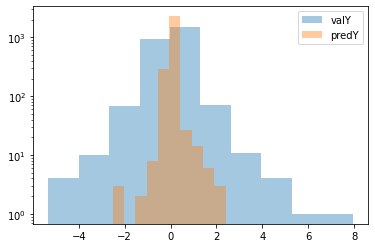

In [ ]:
def estimateResultsForConf(valY,prevY,preds,confidense,valType,target):
    #Estimate results for trading using model predictions with confidense no less then is set in parameter
    if valType=="CHANGES":
        res=1.
        operations=0
        for i in range(len(valY)):
            if preds[i]>confidense:
                res*=1.+valY[i]*NORMALIZATION_K
                operations+=1
            if preds[i]<-confidense:
                res/=1.+valY[i]*NORMALIZATION_K
                operations+=1
    if valType=="ABS": #for absolute values confidense and outcomes are calculated based on prevoius prices
        res=1.
        operations=0
        for i in range(len(valY)):
            pred=denorm(target,preds[i],valType)/denorm(target,prevY[i],valType)-1
            real=denorm(target,valY[i],valType)/denorm(target,prevY[i],valType)-1
            if pred>confidense:
                res*=1+real
                operations+=1
            if pred<-confidense:
                res/=1+real
                operations+=1
    return res-1.,operations

def estimateHold(valRefs,prevValRefs,valType,target):
    #Estimate results of buy-and-hold for test dataset
    if valType=="CHANGES":
        targetHold=1
        sapHold=1
        for i in range(len(valRefs[0])):
            targetHold*=1.+valRefs[0][i]*NORMALIZATION_K
            sapHold*=1.+valRefs[1][i]*NORMALIZATION_K
        targetHold-=1
        sapHold-=1
    if valType=="ABS":
        targetHold=1
        sapHold=1
        for i in range(len(valRefs[0])):
            change=denorm(target,valRefs[0][i],valType)/denorm(target,prevValRefs[0][i],valType)-1
            targetHold*=1.+change
            change=denorm("S&P",valRefs[1][i],valType)/denorm("S&P",prevValRefs[1][i],valType)-1
            sapHold*=1.+change
        targetHold-=1
        sapHold-=1
    return targetHold,sapHold

def estimateResults(valY,prevY,preds,refs,prevRefs,valType,target,verb=False,confs=[0,0.075,0.15,0.3,0.4,0.45,0.5,0.55,0.6,0.75,0.8,0.90,0.95,0.99]):
    if valType=="CHANGES": #confidense levels are obtained from absolute value of predictions
        predConfVals=np.abs(preds)
    if valType=="ABS": #in case of absolute values, price change predictions should be estimated based on previous values
        predConfVals=np.abs(denorm(target,preds.reshape(-1),valType)/denorm(target,prevY,valType)-1)
    predConfVals=sorted(predConfVals)
    confsAbs=[] #absolute confidense levels based on relative levels and predictions
    for conf in confs:
        confsAbs.append(predConfVals[int(len(predConfVals)*conf)])
    targetHold,sapHold=estimateHold(refs,prevRefs,valType,target) #estimate reference buy-and-hold results
    if verb:
        print("Target hold -> {:.2f}%".format(targetHold*100.))
        print("S&P hold -> {:.2f}%".format(sapHold*100.))
    results=[]
    for conf in confsAbs: #estimate results for each confidense level
        res,operations=estimateResultsForConf(valY,prevY,preds,conf,valType,target)
        if verb:
            print("Confidense {:.4f}".format(conf),"-> {:.2f}".format(res*100.),"% in",operations,"operations","## Target mean hold -> {:.2f}%".format(targetHold*100.*operations/len(preds))+" # S&P mean hold -> {:.2f}%".format(sapHold*100.*operations/len(preds)))
        results.append((res,operations))
    if verb:
        plt.figure()
        log=True
        plotDistribution(valY*100*NORMALIZATION_K,log,'valY')
        plotDistribution(preds*100*NORMALIZATION_K,log,'predY')
    return results

def plotLoss(hists):
  if not (type(hists) is list):
      hists=[hists]
  if not (hists[0] is None):
    plt.figure(figsize=(20,5))
    plt.title("loss")
    for i,hist in enumerate(hists):
      plt.plot(hist.history["loss"],c="b",label="Train" if i==0 else "",alpha=0.4)
      plt.plot(hist.history["val_loss"],c='r',label="Validation" if i==0 else "",alpha=0.4)
    plt.legend()

print("Validation time","{:.1f}".format(len(valY)/365.),'years,',len(valY),'operations')
estimateResults(valY,prevY,preds,valRefs,prevValRefs,"CHANGES","USD",True);
plotLoss(hist)

According to Efficient-market hypothesis (https://en.wikipedia.org/wiki/Efficient-market_hypothesis) it is hard to constantly "beat the market", so S&P 500 index (as US market approximation) buy-and-hold is a good enough strategy for comparing results. Also if price of some stock always goes up or down it's easy to profit with little or no influence of strategy. So, target stock buy-and-hold is also taken for comparison.<br>
It can be good to do trading operations only in days when model is confident enough (has a big absolute value of change prediction which can be seen as an approximation of expected value). So different confidense levels are taken into consideration and compared with mean buy-and-hold results for this amount of operations/days (buy-and-hold strategy doesn't distinguish days, while model can take only specific days which can be also good for buy-and-hold).
<br><br> / По гипотезе эффективного рынка (https://ru.wikipedia.org/wiki/%D0%93%D0%B8%D0%BF%D0%BE%D1%82%D0%B5%D0%B7%D0%B0_%D1%8D%D1%84%D1%84%D0%B5%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%BE%D0%B3%D0%BE_%D1%80%D1%8B%D0%BD%D0%BA%D0%B0) тяжело постоянно "побеждать рынок", поэтому изменение индекса S&P 500 (как приблизительная оценка рынка США) может быть использована для сравнения с результатами торговли модели. Также, если котировка постоянно растёт или падает, нетрудно получать прибыль практически с любой стратегией. Поэтому изменение целевой котировки за время валидации также используется в сравнении.<br>
Имеет смысл отдельно рассматривать торговые операции в те дни, когда модель достаточно уверена в прогнозе (предсказывает большой модуль изменения цены, которое можно рассматривать как приближение к мат.ожиданию изменения цены). Поэтому расчитываются результаты для разных уровни уверенности и сравниваются со средними значениями изменений котировок для полученного количества операций/дней (в стратегии покупки и удержания дни не отличаются друг от друга, в то время как модель может выбрать особенные дни, которые также могут быть хороши и для этой стратегии).

# <h3>Training and cross-validation for chosen hyperparameters / Обучение и кросс-валидация для заданных гиперпараметров</h3>

Training and validation results can vary significantly for different dataset splits. For more reliable results and for hyperparameters affect estimation, several iterations of dataset split and model training are executed. In the end the results of trained models with chosen hyperparameters are analized.<br> / Результаты обучения и валидации могут сильно меняться от случайного разбиения датасетов. Для надёжного получения результатов и для изучения влияния параметров на точность модели запускается несколько итераций случайного разибения датасета и обучений на этих разбиениях. В конце проводится анализ исходов для полученных моделей с данными гиперпараметрами.

In [ ]:
ITERS=128 #number of iterations for dataset split and training
confs=[0,0.075,0.15,0.3,0.4,0.45,0.5,0.55,0.6,0.75,0.8,0.90,0.95,0.99] #confidense levels (0..1) for estimation

datasetParams={} #parameters for dataset
datasetParams["TYPE"]="ABS" #value type: "ABS" for normalized prices from -0.5 to 0.5, "CHANGES" for relative change on each day
datasetParams["TARGET"]="USD" #target stock
datasetParams["CHUNK_SIZE"]=20 #chunk size in days for dataset random splitting
datasetParams["FRAMES"]=5 #number of previous days to be used in X for training and prediction of a single y
datasetParams["USE"]=["USD","S&P","Alum","IMOEX","Petrol","Gold","NatGas","Brent","CNY"] #stocks to be used in training and prediction (defined in "Dataset preparation")
datasetParams["VAL_SPLIT"]=0.35 #validation dataset part in split

trainingParams={} #parameters for training
trainingParams["FUNC"]=trainXGB #main function to be used: trainXGB for XGBoost, trainTF for Tensorflow (defined in "Functions for model training")
#trainingParams["LOSS"]="mse" #loss function (for Tensorflow)

def runTests(dateData,ITERS,confs,datasetParamsOrig,trainingParamsOrig):
    #Run several iterations of dataset split, train and estimation
    #make a copy of parameters to be filled by default values instead of missing
    dataSetParams,trainingParams=datasetParamsOrig.copy(),trainingParamsOrig.copy()
    confsRes=np.zeros((len(confs),ITERS))
    confsOpsRes=np.zeros((len(confs),ITERS))
    totalValFrames=np.zeros(ITERS)
    refsRes=np.zeros((ITERS,2))
    hists=[]
    for i in range(ITERS):
        print('Training',i+1,'/',ITERS)
        #get random dataset split
        trainX,indTrainX,trainY,valX,indValX,valY,valRefs,prevValRefs,prevY=prepareRandomDataset(dateData,False,datasetParams)
        totalValFrames[i]=len(valY)
        refsRes[i]=estimateHold(valRefs,prevValRefs,datasetParams["TYPE"],datasetParams["TARGET"])
        #train model on this split
        preds,hist=trainingParams["FUNC"](trainX,indTrainX,trainY,valX,indValX,trainingParams)
        hists.append(hist)
        #estimate and save results
        results=estimateResults(valY,prevY,preds,valRefs,prevValRefs,datasetParams["TYPE"],datasetParams["TARGET"],False,confs)
        for j in range(len(confs)):
            confsRes[j][i]=results[j][0]*100.
            confsOpsRes[j][i]=results[j][1]
    #clear output when iterations are done
    clear_output()
    #output statistics for global mean buy-and-holds and for confidense levels
    print(ITERS,'trainings done')
    plotLoss(hists)
    print("Target hold -> {:.2f}%".format(refsRes[:,0].mean()*100.)+" # S&P hold -> {:.2f}%".format(refsRes[:,1].mean()*100.))
    for i in range(len(confsRes)):
        ops=confsOpsRes[i,:].mean()
        total=totalValFrames.mean()
        print('confidense '+str(confs[i])+" -> "+"{:.2f}%".format(confsRes[i].mean()),"## in",int(ops),"operations ## Target mean hold -> {:.2f}%".format(refsRes[:,0].mean()*100.*ops/total)+" # S&P mean hold -> {:.2f}%".format(refsRes[:,1].mean()*100.*ops/total))
    plt.figure(figsize=(30,3))
    plt.subplot(1,len(confsRes)+1,1)
    plt.hist(refsRes[:,0]*100.,color='b',label="Target",alpha=0.6)
    plt.hist(refsRes[:,1]*100.,color='g',label="S&P",alpha=0.6)
    plt.legend()
    plt.title("Hold")
    for i in range(len(confsRes)):
        plt.subplot(1,len(confsRes)+1,i+2)
        plt.hist(confsRes[i],label="Target pred",color='r',alpha=0.8)
        ops=confsOpsRes[i,:].mean()
        total=totalValFrames.mean()
        plt.hist(refsRes[:,0]*100.*ops/total,color='b',label="targ mh",alpha=0.4)
        plt.hist(refsRes[:,1]*100.*ops/total,color='g',label="S&P mh",alpha=0.4)
        plt.legend()
        plt.title('conf '+str(confs[i])+" -> "+"{:.2f}%".format(confsRes[i].mean()))

## XGBoost training

128 trainings done
Target hold -> 44.93% # S&P hold -> 68.72%
confidense 0 -> 33.89% ## in 2504 operations ## Target mean hold -> 44.92% # S&P mean hold -> 68.70%
confidense 0.075 -> 33.65% ## in 2317 operations ## Target mean hold -> 41.55% # S&P mean hold -> 63.56%
confidense 0.15 -> 32.38% ## in 2129 operations ## Target mean hold -> 38.18% # S&P mean hold -> 58.40%
confidense 0.3 -> 30.33% ## in 1753 operations ## Target mean hold -> 31.44% # S&P mean hold -> 48.09%
confidense 0.4 -> 26.30% ## in 1502 operations ## Target mean hold -> 26.95% # S&P mean hold -> 41.22%
confidense 0.45 -> 26.01% ## in 1377 operations ## Target mean hold -> 24.70% # S&P mean hold -> 37.79%
confidense 0.5 -> 22.66% ## in 1252 operations ## Target mean hold -> 22.46% # S&P mean hold -> 34.35%
confidense 0.55 -> 21.97% ## in 1126 operations ## Target mean hold -> 20.21% # S&P mean hold -> 30.91%
confidense 0.6 -> 19.18% ## in 1001 operations ## Target mean hold -> 17.97% # S&P mean hold -> 27.48%
confiden

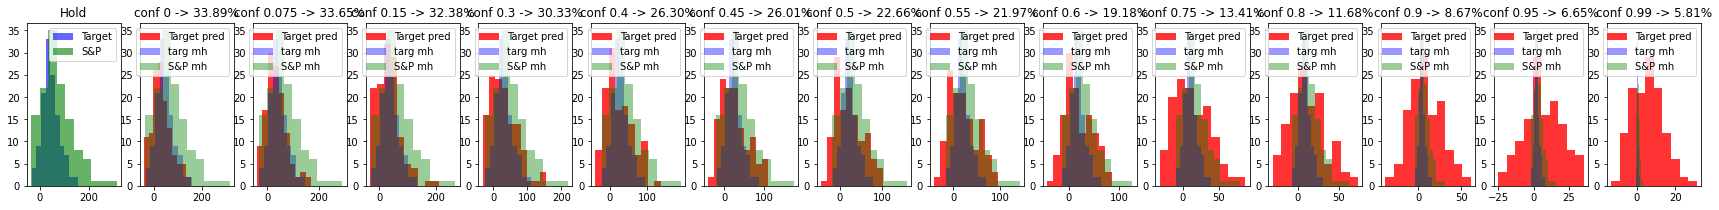

In [ ]:
datasetParams["USE"]=["USD","S&P","Gold","Brent"]
trainingParams["FUNC"]=trainXGB
runTests(dateData,ITERS,confs,datasetParams,trainingParams)

## Dense NN training

64 trainings done
Target hold -> 41.35% # S&P hold -> 79.27%
confidense 0 -> 79.46% ## in 2468 operations ## Target mean hold -> 41.34% # S&P mean hold -> 79.26%
confidense 0.075 -> 77.78% ## in 2283 operations ## Target mean hold -> 38.24% # S&P mean hold -> 73.32%
confidense 0.15 -> 73.68% ## in 2097 operations ## Target mean hold -> 35.14% # S&P mean hold -> 67.36%
confidense 0.3 -> 60.01% ## in 1727 operations ## Target mean hold -> 28.94% # S&P mean hold -> 55.47%
confidense 0.4 -> 48.60% ## in 1480 operations ## Target mean hold -> 24.80% # S&P mean hold -> 47.54%
confidense 0.45 -> 43.08% ## in 1357 operations ## Target mean hold -> 22.73% # S&P mean hold -> 43.58%
confidense 0.5 -> 40.26% ## in 1233 operations ## Target mean hold -> 20.67% # S&P mean hold -> 39.62%
confidense 0.55 -> 37.23% ## in 1110 operations ## Target mean hold -> 18.60% # S&P mean hold -> 35.65%
confidense 0.6 -> 31.72% ## in 986 operations ## Target mean hold -> 16.53% # S&P mean hold -> 31.69%
confidense

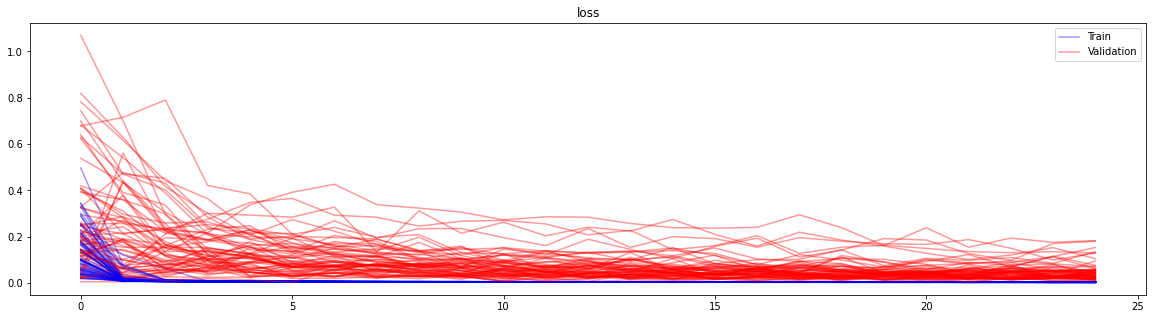

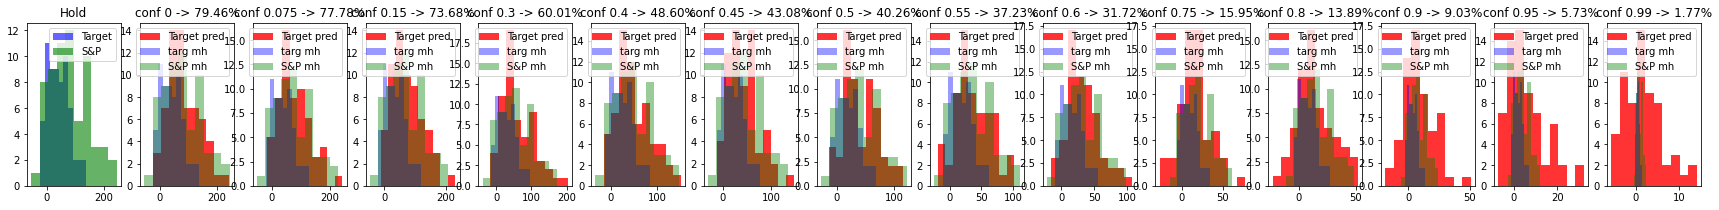

In [ ]:
ITERS=64
trainingParams["FUNC"]=trainTF
trainingParams["LOSS"]="mse"
trainingParams["ITERS"]=25
trainingParams["LAYERS"]=[32]
trainingParams["MODEL"]=buildDense
runTests(dateData,ITERS,confs,datasetParams,trainingParams)

64 trainings done
Target hold -> 39.39% # S&P hold -> 87.06%
confidense 0 -> 61.83% ## in 2458 operations ## Target mean hold -> 39.38% # S&P mean hold -> 87.04%
confidense 0.075 -> 56.51% ## in 2274 operations ## Target mean hold -> 36.43% # S&P mean hold -> 80.52%
confidense 0.15 -> 56.49% ## in 2089 operations ## Target mean hold -> 33.47% # S&P mean hold -> 73.98%
confidense 0.3 -> 45.34% ## in 1721 operations ## Target mean hold -> 27.56% # S&P mean hold -> 60.92%
confidense 0.4 -> 38.63% ## in 1475 operations ## Target mean hold -> 23.63% # S&P mean hold -> 52.22%
confidense 0.45 -> 35.39% ## in 1352 operations ## Target mean hold -> 21.65% # S&P mean hold -> 47.86%
confidense 0.5 -> 30.95% ## in 1229 operations ## Target mean hold -> 19.69% # S&P mean hold -> 43.51%
confidense 0.55 -> 27.79% ## in 1106 operations ## Target mean hold -> 17.72% # S&P mean hold -> 39.16%
confidense 0.6 -> 25.93% ## in 983 operations ## Target mean hold -> 15.75% # S&P mean hold -> 34.80%
confidense

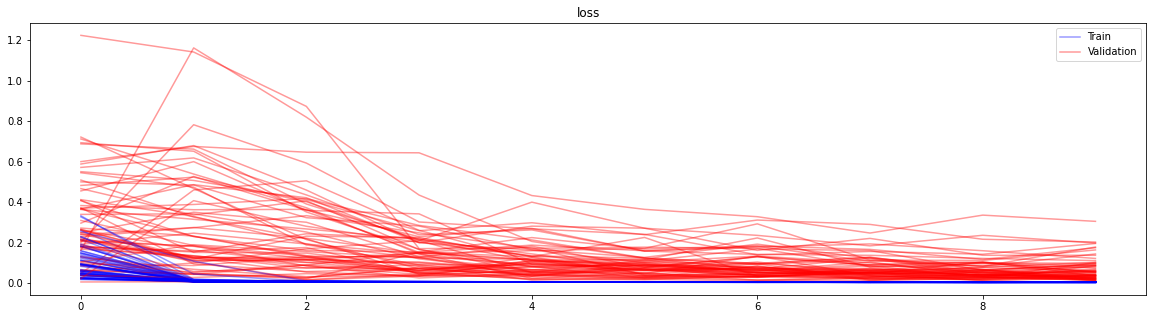

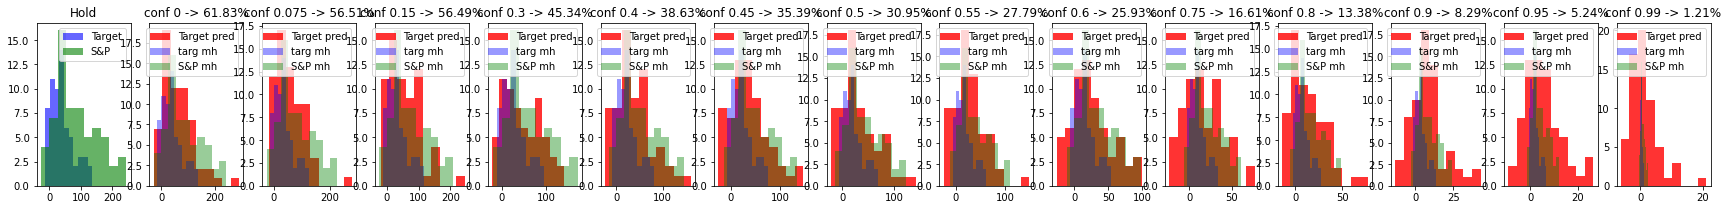

In [ ]:
trainingParams["FUNC"]=trainTF
trainingParams["LOSS"]="mse"
datasetParams["FRAMES"]=5
trainingParams["ITERS"]=10
trainingParams["LAYERS"]=[64]
trainingParams["MODEL"]=buildDense
runTests(dateData,ITERS,confs,datasetParams,trainingParams)

64 trainings done
Target hold -> 35.77% # S&P hold -> 72.16%
confidense 0 -> 79.17% ## in 2498 operations ## Target mean hold -> 35.76% # S&P mean hold -> 72.15%
confidense 0.075 -> 79.71% ## in 2311 operations ## Target mean hold -> 33.08% # S&P mean hold -> 66.74%
confidense 0.15 -> 75.34% ## in 2123 operations ## Target mean hold -> 30.39% # S&P mean hold -> 61.32%
confidense 0.3 -> 54.08% ## in 1748 operations ## Target mean hold -> 25.03% # S&P mean hold -> 50.50%
confidense 0.4 -> 40.98% ## in 1499 operations ## Target mean hold -> 21.45% # S&P mean hold -> 43.28%
confidense 0.45 -> 34.08% ## in 1374 operations ## Target mean hold -> 19.66% # S&P mean hold -> 39.67%
confidense 0.5 -> 31.08% ## in 1249 operations ## Target mean hold -> 17.88% # S&P mean hold -> 36.07%
confidense 0.55 -> 26.78% ## in 1124 operations ## Target mean hold -> 16.09% # S&P mean hold -> 32.46%
confidense 0.6 -> 24.03% ## in 999 operations ## Target mean hold -> 14.30% # S&P mean hold -> 28.85%
confidense

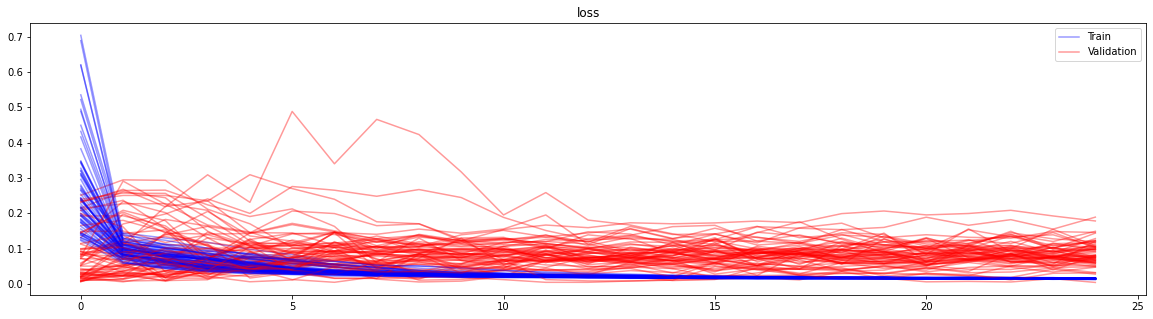

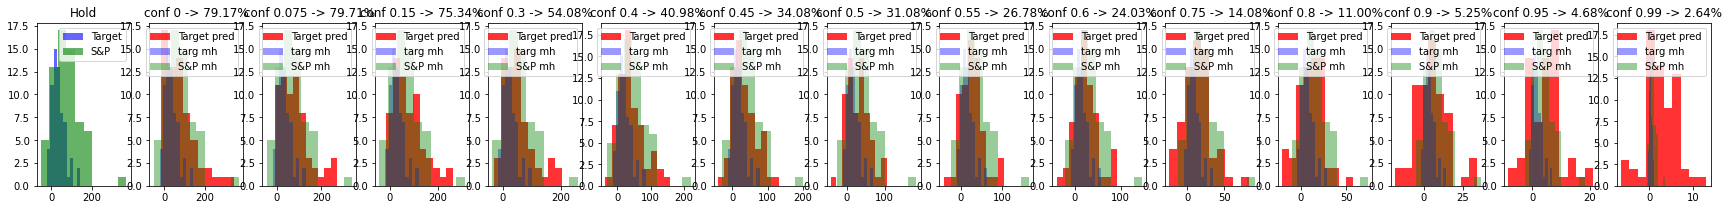

In [ ]:
trainingParams["FUNC"]=trainTF
trainingParams["LOSS"]="mse"
trainingParams["LAYERS"]=[32,32]
trainingParams["DROPOUT"]=0.3
trainingParams["MODEL"]=buildDense
runTests(dateData,ITERS,confs,datasetParams,trainingParams)

## CNN training

64 trainings done
Target hold -> 42.18% # S&P hold -> 69.22%
confidense 0 -> 64.42% ## in 2502 operations ## Target mean hold -> 42.17% # S&P mean hold -> 69.21%
confidense 0.075 -> 64.06% ## in 2315 operations ## Target mean hold -> 39.02% # S&P mean hold -> 64.03%
confidense 0.15 -> 60.58% ## in 2127 operations ## Target mean hold -> 35.85% # S&P mean hold -> 58.83%
confidense 0.3 -> 55.92% ## in 1751 operations ## Target mean hold -> 29.52% # S&P mean hold -> 48.45%
confidense 0.4 -> 47.67% ## in 1501 operations ## Target mean hold -> 25.30% # S&P mean hold -> 41.53%
confidense 0.45 -> 45.37% ## in 1376 operations ## Target mean hold -> 23.19% # S&P mean hold -> 38.06%
confidense 0.5 -> 41.93% ## in 1251 operations ## Target mean hold -> 21.08% # S&P mean hold -> 34.60%
confidense 0.55 -> 36.63% ## in 1126 operations ## Target mean hold -> 18.98% # S&P mean hold -> 31.14%
confidense 0.6 -> 30.90% ## in 1000 operations ## Target mean hold -> 16.86% # S&P mean hold -> 27.68%
confidens

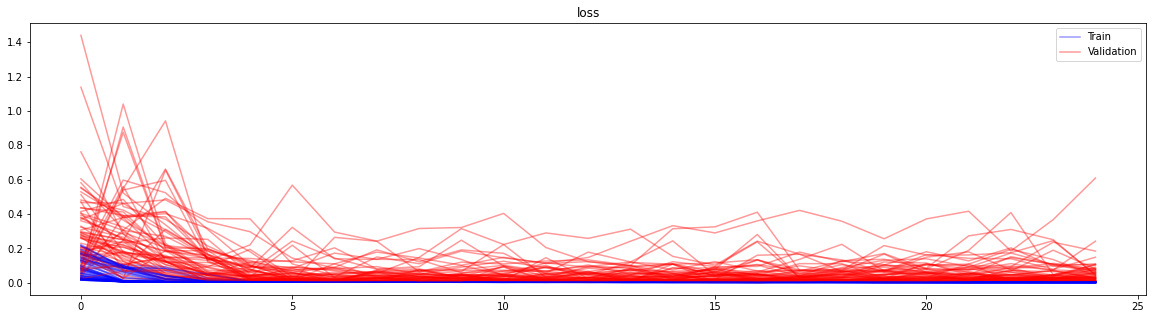

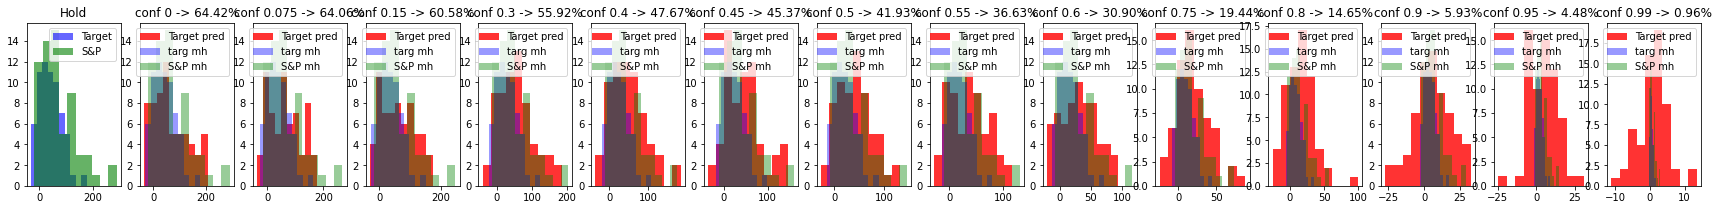

In [ ]:
trainingParams["FUNC"]=trainTF
trainingParams["LOSS"]="mse"
datasetParams["FRAMES"]=15
trainingParams["LAYERS"]=[16,16]
trainingParams["FILTERS_SIZE"]=[6,3]
trainingParams["DENSE_LAYERS"]=[16]
trainingParams["DROPOUT"]=0
trainingParams["MODEL"]=buildCNN
runTests(dateData,ITERS,confs,datasetParams,trainingParams)

64 trainings done
Target hold -> 39.96% # S&P hold -> 68.93%
confidense 0 -> 45.27% ## in 2483 operations ## Target mean hold -> 39.95% # S&P mean hold -> 68.91%
confidense 0.075 -> 44.51% ## in 2297 operations ## Target mean hold -> 36.96% # S&P mean hold -> 63.76%
confidense 0.15 -> 43.66% ## in 2111 operations ## Target mean hold -> 33.96% # S&P mean hold -> 58.59%
confidense 0.3 -> 40.68% ## in 1738 operations ## Target mean hold -> 27.96% # S&P mean hold -> 48.24%
confidense 0.4 -> 38.36% ## in 1490 operations ## Target mean hold -> 23.97% # S&P mean hold -> 41.36%
confidense 0.45 -> 35.41% ## in 1365 operations ## Target mean hold -> 21.97% # S&P mean hold -> 37.90%
confidense 0.5 -> 30.68% ## in 1241 operations ## Target mean hold -> 19.97% # S&P mean hold -> 34.45%
confidense 0.55 -> 28.20% ## in 1117 operations ## Target mean hold -> 17.98% # S&P mean hold -> 31.01%
confidense 0.6 -> 25.13% ## in 993 operations ## Target mean hold -> 15.98% # S&P mean hold -> 27.56%
confidense

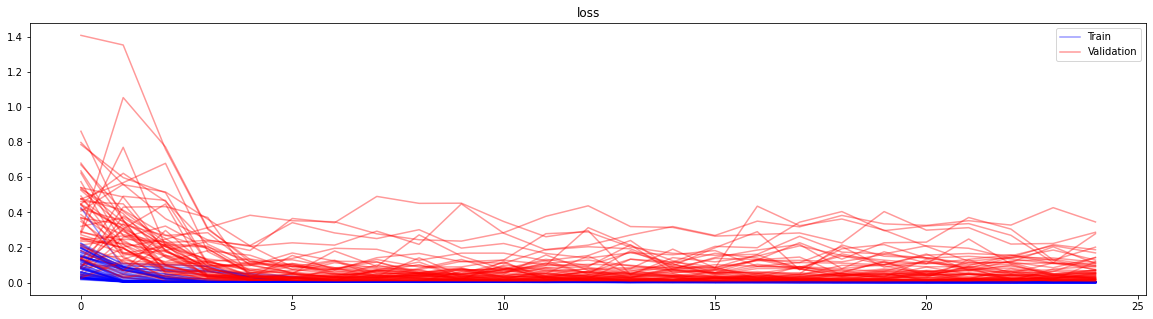

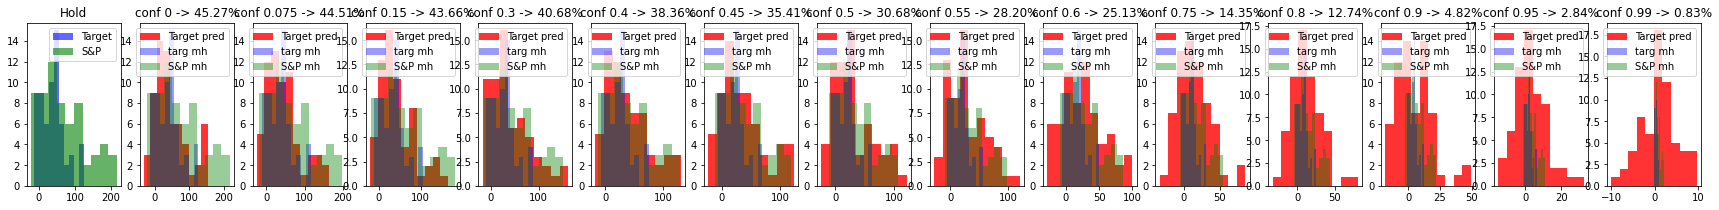

In [ ]:
trainingParams["FUNC"]=trainTF
trainingParams["LOSS"]="mse"
datasetParams["FRAMES"]=15
trainingParams["LAYERS"]=[16,16,16]
trainingParams["FILTERS_SIZE"]=3
trainingParams["MODEL"]=buildCNN
runTests(dateData,ITERS,confs,datasetParams,trainingParams)

64 trainings done
Target hold -> 41.93% # S&P hold -> 74.31%
confidense 0 -> 46.17% ## in 2461 operations ## Target mean hold -> 41.92% # S&P mean hold -> 74.29%
confidense 0.075 -> 48.67% ## in 2276 operations ## Target mean hold -> 38.78% # S&P mean hold -> 68.73%
confidense 0.15 -> 46.82% ## in 2092 operations ## Target mean hold -> 35.63% # S&P mean hold -> 63.15%
confidense 0.3 -> 39.94% ## in 1722 operations ## Target mean hold -> 29.34% # S&P mean hold -> 52.00%
confidense 0.4 -> 33.61% ## in 1476 operations ## Target mean hold -> 25.15% # S&P mean hold -> 44.57%
confidense 0.45 -> 32.68% ## in 1353 operations ## Target mean hold -> 23.05% # S&P mean hold -> 40.86%
confidense 0.5 -> 32.42% ## in 1230 operations ## Target mean hold -> 20.95% # S&P mean hold -> 37.14%
confidense 0.55 -> 31.44% ## in 1107 operations ## Target mean hold -> 18.86% # S&P mean hold -> 33.43%
confidense 0.6 -> 29.08% ## in 984 operations ## Target mean hold -> 16.76% # S&P mean hold -> 29.71%
confidense

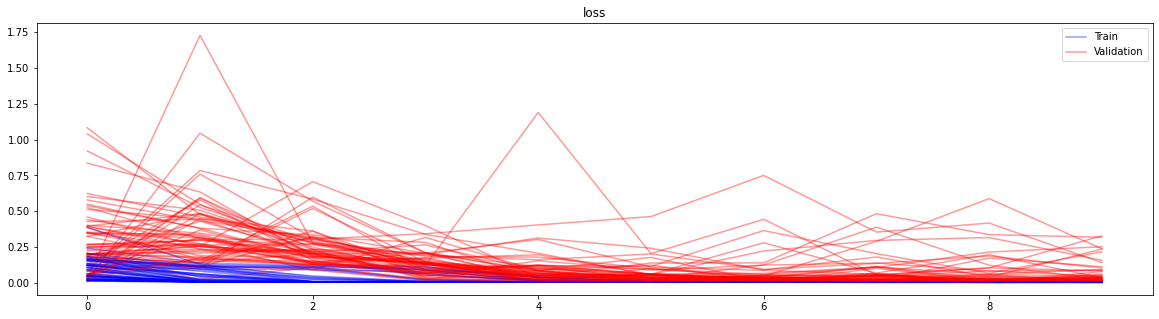

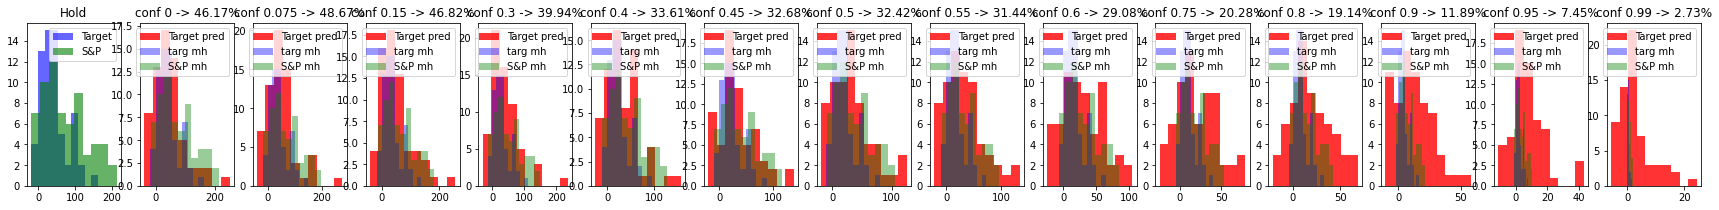

In [ ]:
trainingParams["FUNC"]=trainTF
trainingParams["LOSS"]="mse"
datasetParams["FRAMES"]=15
trainingParams["LAYERS"]=[32]
trainingParams["ITERS"]=10
trainingParams["FILTERS_SIZE"]=15
trainingParams["MODEL"]=buildCNN
runTests(dateData,ITERS,confs,datasetParams,trainingParams)

64 trainings done
Target hold -> 42.92% # S&P hold -> 78.31%
confidense 0 -> 47.67% ## in 2489 operations ## Target mean hold -> 42.91% # S&P mean hold -> 78.30%
confidense 0.075 -> 46.22% ## in 2302 operations ## Target mean hold -> 39.70% # S&P mean hold -> 72.43%
confidense 0.15 -> 46.09% ## in 2116 operations ## Target mean hold -> 36.48% # S&P mean hold -> 66.56%
confidense 0.3 -> 37.51% ## in 1742 operations ## Target mean hold -> 30.04% # S&P mean hold -> 54.80%
confidense 0.4 -> 31.36% ## in 1493 operations ## Target mean hold -> 25.75% # S&P mean hold -> 46.98%
confidense 0.45 -> 27.26% ## in 1368 operations ## Target mean hold -> 23.60% # S&P mean hold -> 43.06%
confidense 0.5 -> 24.31% ## in 1244 operations ## Target mean hold -> 21.45% # S&P mean hold -> 39.14%
confidense 0.55 -> 21.67% ## in 1120 operations ## Target mean hold -> 19.31% # S&P mean hold -> 35.23%
confidense 0.6 -> 18.61% ## in 995 operations ## Target mean hold -> 17.16% # S&P mean hold -> 31.31%
confidense

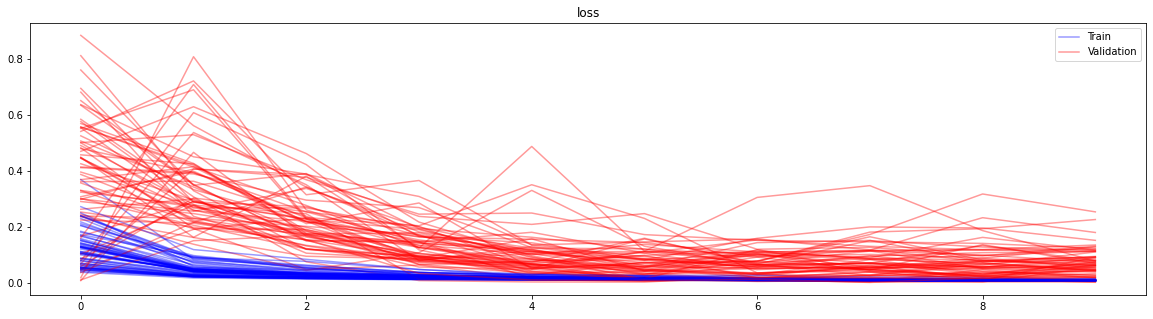

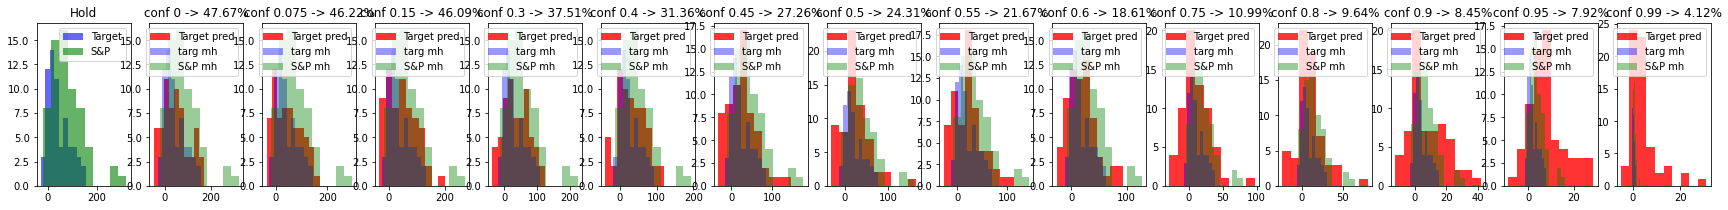

In [ ]:
trainingParams["FUNC"]=trainTF
trainingParams["LOSS"]="mse"
datasetParams["FRAMES"]=15
trainingParams["LAYERS"]=[32,16]
trainingParams["FILTERS_SIZE"]=[6,3]
trainingParams["DENSE_LAYERS"]=[32,32]
trainingParams["DROPOUT"]=0
trainingParams["MODEL"]=buildCNN
trainingParams["DENSE_DROPOUT"]=0.1
runTests(dateData,ITERS,confs,datasetParams,trainingParams)